# ケプストログラムの表示

In [5]:
import pandas as pd
import numpy as np
import pathlib as Path
from scipy.fft import fft, ifft
from cutill.x64.Release import cutill as c
from utills.preprocess import is_tolerance

fs = 128            # サンプリング周波数
frame_time = 10     # 10秒間隔
interval_time = 4   # 4秒ごとに切り出す
frame_width = int(frame_time*fs)    # 窓幅(1280)

# 不整合データのパラメータ
tolerance_max = 4000.0
tolerance_min = 96.0

# スペクトル描画のパラメータ
spe_high_cutoff = 64
spe_low_cutoff = 0
spe_n_samples = spe_high_cutoff - spe_low_cutoff

# ケプストラム生成のパラメータ
cep_high_cutoff = 50
cep_low_cutoff = 3
cep_n_samples = cep_high_cutoff - cep_low_cutoff

assert 0 < cep_n_samples, "The low value is greater than the high value"

### 必要関数群

In [6]:
def read_csv(dir: Path, integrity_check=True):
    '''
    csvの読み込み

    Args:
        dir : pathlib(Path)

    Returns:
        ldata = ndarray
        rdata = ndarray
        pdata = ndarray
    '''
    # pandasでcsvを読み込み
    wave = pd.read_csv(".."/dir/"wave.csv", names=["L", "R", "L_gain", "R_gain"])
    posture = pd.read_csv(".."/dir/"position.csv")

    # waveの長さ [s]
    wave_time = int(len(wave)/fs)
    rdata = np.empty((0, frame_width))   # rightの最終的な配列
    ldata = np.empty((0, frame_width))   # leftの最終的な配列
    pdata = np.empty(0)            # positionの最終的な配列を格納するndarray
    i = 0

    # rawデータの切り出し
    for start in range(0, wave_time-frame_time, interval_time):
        i += 1
        # waveとpositionを4秒間隔で10秒間スライス
        window = wave[start*fs : (start + frame_time)*fs]
        pos = posture[start : start + frame_time]

        # waveとをnumpy配列に変換
        lraw = window['L'].to_numpy()
        rraw = window['R'].to_numpy()
        lgain = window['L_gain'].to_numpy()
        rgain = window['R_gain'].to_numpy()
        pos = pos.to_numpy()

        # データの整合性を確認
        if integrity_check:
            if not c.is_identical_element(rgain) or not c.is_identical_element(lgain):
                continue
            if not is_tolerance(rraw) or not is_tolerance(lraw):
                continue
            if not c.is_identical_element(pos):
                continue
            if np.any(pos == 0):
                continue

        # 波形の復元
        left = lraw * 2.818 ** lgain
        right = rraw * 2.818 ** rgain
        
        left = left.astype(np.float32)
        right = right.astype(np.float32)

        ldata = np.vstack((ldata, left)) if ldata.size else left
        rdata = np.vstack((rdata, right)) if rdata.size else right
        pdata = np.append(pdata, pos[0])

    return ldata, rdata, pos

def wave_cut(wave: np.ndarray, start=None, end=None):
    '''
    波形のカット

    Args:
        wave: ndarray
        start: int
        end: int
    
    Return:
        wave: ndarray
    '''
    if start is not None and end is not None:
        return wave[start*fs: end*fs]
    else:
        if start is not None:
            return wave[start*fs:]
        if end is not None:
            return wave[:end*fs]
        return wave
    
def stft(wave: np.ndarray):
    '''
    短時間フーリエ変換

    Args:
        wave: ndarray

    Returs:
        Sxx: ndarray(2D)
        tdata: ndarray
    '''

    wave_time = int(len(wave)/fs)   # waveの長さ[s]
    Sxx = np.empty((0, (fs*frame_time)//2))      # 切り出し後のwaveスタック
    tdata = np.empty([0])                   # 切り出し後のwaveスタックに対応した時間ラベル
    han = np.hanning(frame_width)     # ハン窓
    t = 0
    
    if wave.ndim == 1:
        for start in range(0, wave_time-frame_time, interval_time):
            # 切り出し処理
            w = wave[start*fs : (start+frame_time)*fs] * han
            t = start + interval_time + 1

            # DTFT -> 対数振幅スペクトルに変換
            f = fft(w)[: (fs*frame_time)//2]
            f = np.log10(np.abs(f) + 1e-20)
            f[:8] *= 1e-3   # HPF

            # 結果をSxxとtdataにスタック
            Sxx = np.vstack((Sxx, f)) if Sxx.size else f
            tdata = np.append(tdata, t)
    else:
        for w in wave:
            w *= han
            t += 1

            # DTFT -> 対数振幅スペクトルに変換
            f = fft(w)[: (fs*frame_time)//2]
            f = np.log10(np.abs(f) + 1e-20)
            f[:8] *= 1e-3   # HPF

            # 結果をSxxとtdataにスタック
            Sxx = np.vstack((Sxx, f)) if Sxx.size else f
            tdata = np.append(tdata, t)
        

    return Sxx, tdata

def freq_to_CMN(freq: np.ndarray):
    '''
    周波数領域からケプストラム領域に変換、平均正規化

    Args:
        wave: ndarray(2D)
    
    Returns:
        Sxx: ndarray(2D)
    '''

    cepstrum = np.empty((0, cep_n_samples))
    
    # ケプストラムに変換
    for f in freq:
        c = ifft(f).real[cep_low_cutoff : cep_high_cutoff]
        cepstrum = np.vstack((cepstrum, c)) if cepstrum.size else c
    
    # 平均正規化
    avg_cepstrum = np.mean(cepstrum, axis=0)
    for c in cepstrum:
        c -= avg_cepstrum

    return cepstrum


### 描画関数

In [7]:
import matplotlib.pyplot as plt

def plot_spectrogram(wave : np.ndarray) -> None:
    freq, t = stft(wave)
    f = np.arange(spe_low_cutoff, spe_high_cutoff, 1/frame_time)

    # ケプストログラムのプロット
    plt.figure(figsize=(10, 6), facecolor='none')
    plt.rcParams["font.size"] = 18
    # plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.pcolormesh(t, f, freq.T, shading='auto', cmap='plasma')
    plt.xlabel('index')
    plt.ylabel('frequency[Hz]')
    # plt.axis('off')
    plt.show()    

def plot_cepstrogram(wave : np.ndarray) -> None:
    freq, t = stft(wave)
    cep = freq_to_CMN(freq)
    f = np.arange(cep_low_cutoff, cep_high_cutoff)

    # ケプストログラムのプロット
    plt.figure(figsize=(10, 6), facecolor='none')
    plt.rcParams["font.size"] = 18
    # plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.pcolormesh(t, f, cep.T, shading='auto', cmap='gray')
    plt.xlabel('index')
    plt.ylabel('quefrency[s]')
    # plt.axis('off')
    plt.show()

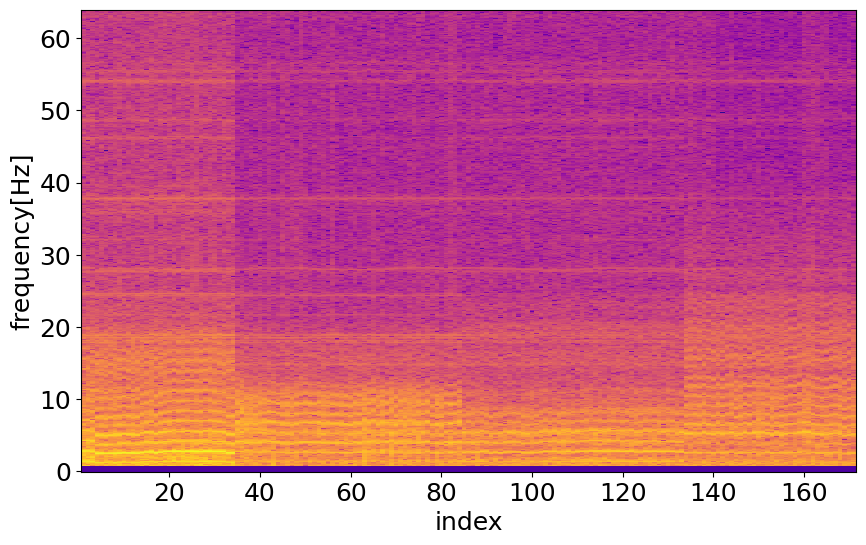

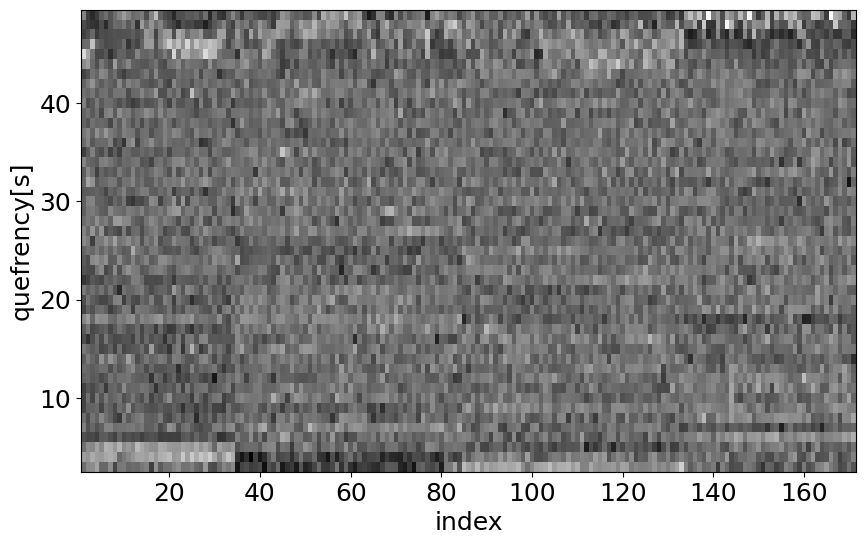

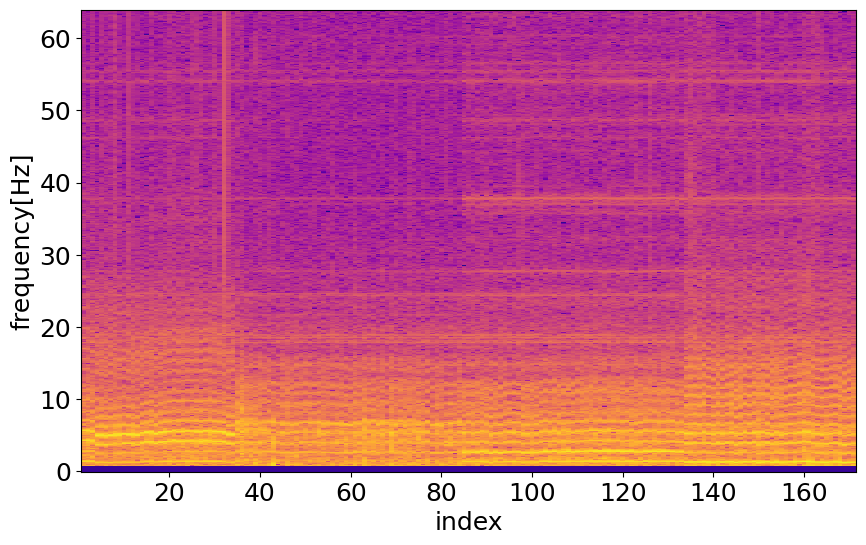

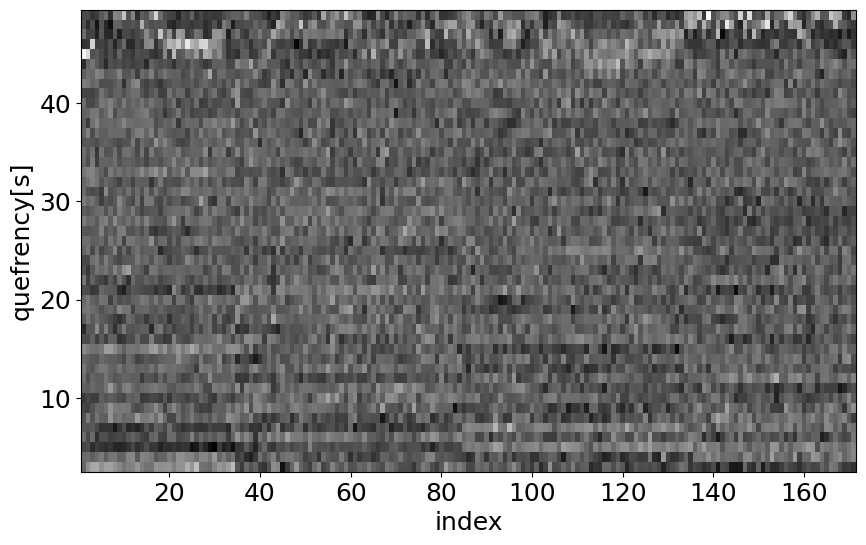

In [8]:
import utills.datapath as dp

tester = dp.LMH.M001.value.ka_center
left, right, _ = read_csv(tester.value, integrity_check=True)

plot_spectrogram(left)
plot_cepstrogram(left)
plot_spectrogram(right)
plot_cepstrogram(right)